In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torchvision.models import resnet34
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [14]:
# 데이터셋 클래스 정의
class ImageDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = torch.tensor(data / 1023.0, dtype=torch.float32).view(-1, 1, 32, 32)  # 0~1023 -> 0~1 정규화
        self.labels = None if labels is None else torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.labels is None:
            return self.data[idx]
        return self.data[idx], self.labels[idx]

In [15]:
class ResNet34Model(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet34Model, self).__init__()
        self.model = resnet34()  # 사전 학습된 가중치 X
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 흑백 이미지 입력
        self.model.fc = nn.Linear(512, num_classes)  # 출력 클래스 개수 조정

    def forward(self, x):
        return self.model(x)

In [16]:
# 데이터 불러오기
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [17]:
# 레이블 인코딩
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['label'])
train_features = train_df.drop(columns=['ID', 'label']).values
test_features = test_df.drop(columns=['ID']).values

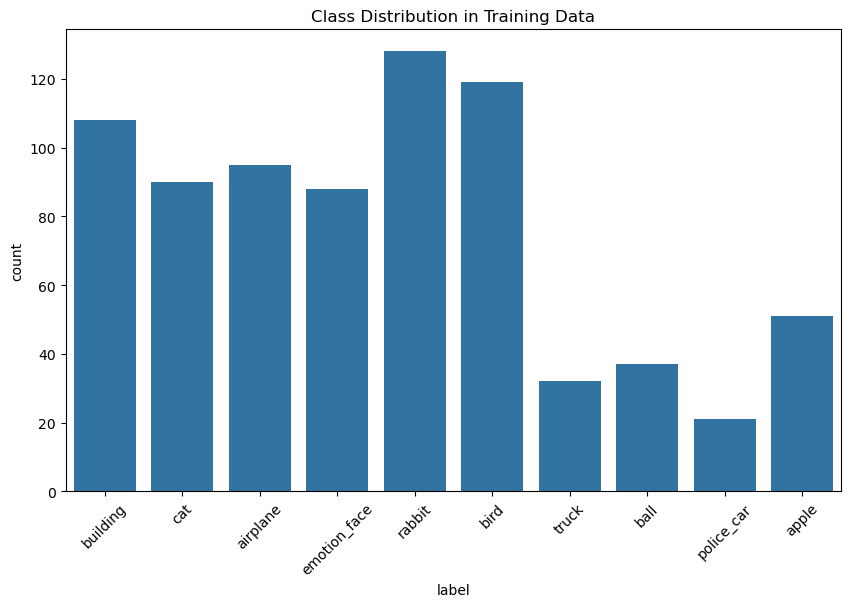

In [18]:
# 데이터 시각화
plt.figure(figsize=(10, 6))
sns.countplot(x=train_df['label'])
plt.xticks(rotation=45)
plt.title("Class Distribution in Training Data")
plt.show()

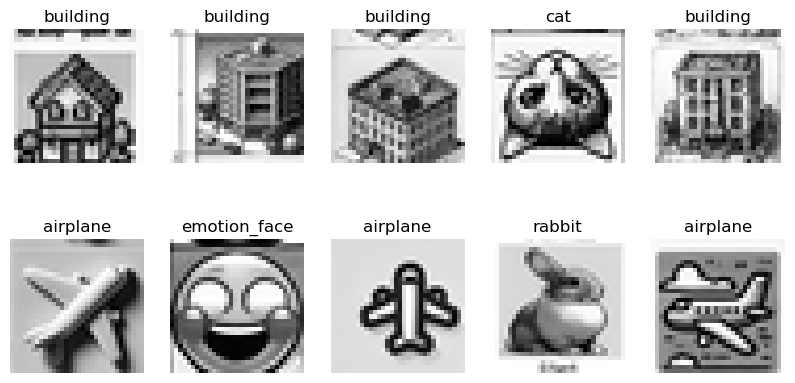

In [19]:
# 샘플 이미지 확인
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    img = train_features[i].reshape(32, 32)
    ax.imshow(img, cmap='gray')
    ax.set_title(label_encoder.inverse_transform([train_labels[i]])[0])
    ax.axis('off')
plt.show()

In [20]:
# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

# 데이터셋 및 데이터로더 생성
train_dataset = ImageDataset(X_train, y_train)
val_dataset = ImageDataset(X_val, y_val)
test_dataset = ImageDataset(test_features)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet34Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)  # Val Loss가 감소하지 않으면 학습률 절반으로 줄이기

num_epochs = 20
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))
    
    # 검증 단계
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    val_losses.append(val_loss / len(val_loader))

    # Val Accuracy 계산
    val_accuracy = correct / float(total)
    val_accuracies.append(val_accuracy)  # val_accuracies에 정확도 추가
    
    # 학습률 스케줄러 업데이트
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1/30, Train Loss: 1.8055, Val Loss: 2.7517, Val Accuracy: 0.0455
Epoch 2/30, Train Loss: 0.6953, Val Loss: 5.5174, Val Accuracy: 0.0195
Epoch 3/30, Train Loss: 0.3108, Val Loss: 2.2393, Val Accuracy: 0.3766
Epoch 4/30, Train Loss: 0.2750, Val Loss: 0.9838, Val Accuracy: 0.7532
Epoch 5/30, Train Loss: 0.4332, Val Loss: 1.1224, Val Accuracy: 0.7078
Epoch 6/30, Train Loss: 0.2690, Val Loss: 1.3050, Val Accuracy: 0.6948
Epoch 7/30, Train Loss: 0.4092, Val Loss: 1.3028, Val Accuracy: 0.6558
Epoch 8/30, Train Loss: 0.2607, Val Loss: 0.5400, Val Accuracy: 0.8442
Epoch 9/30, Train Loss: 0.0848, Val Loss: 0.6481, Val Accuracy: 0.8442
Epoch 10/30, Train Loss: 0.0777, Val Loss: 0.6063, Val Accuracy: 0.8312
Epoch 11/30, Train Loss: 0.0797, Val Loss: 0.6683, Val Accuracy: 0.8117
Epoch 12/30, Train Loss: 0.0700, Val Loss: 0.5445, Val Accuracy: 0.8571
Epoch 13/30, Train Loss: 0.0296, Val Loss: 0.5098, Val Accuracy: 0.8636
Epoch 14/30, Train Loss: 0.0238, Val Loss: 0.4755, Val Accuracy: 0.8766
E

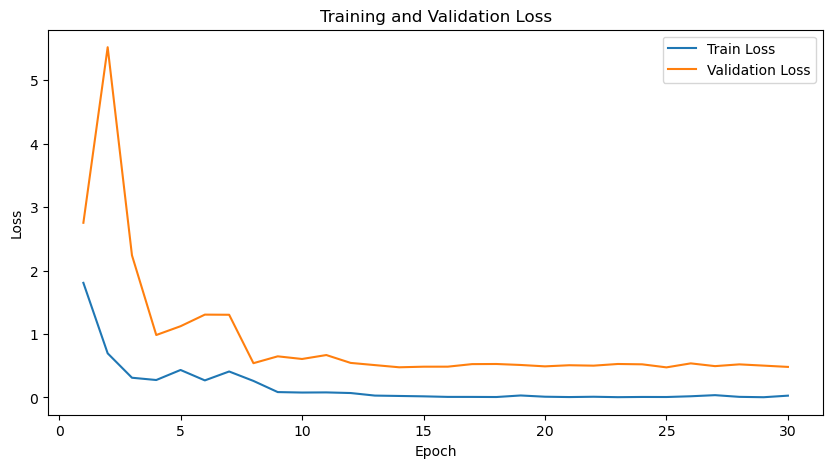

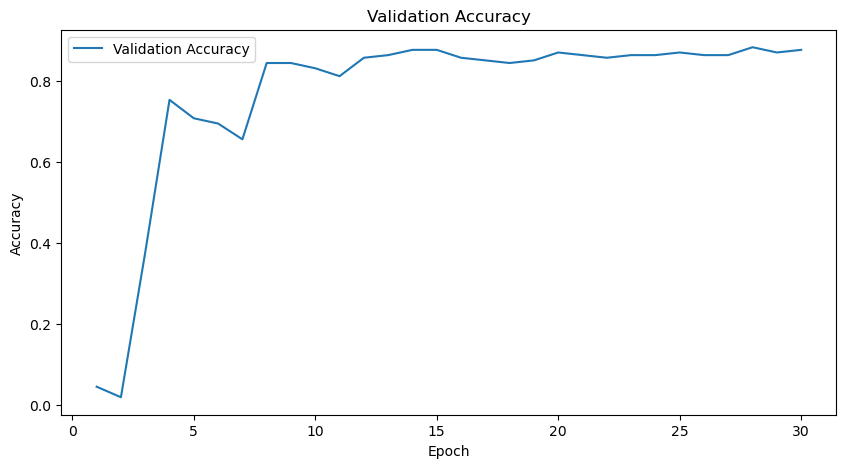

In [22]:
# 학습 곡선 시각화
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

In [23]:
# 예측 및 저장
model.eval()
predictions = []
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        predictions.extend(preds)

In [24]:
# 결과 저장
submission = pd.DataFrame({"ID": test_df["ID"], "label": label_encoder.inverse_transform(predictions)})
submission.to_csv("submission.csv", index=False)